In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from datetime import datetime
import scipy

In [2]:
#string to datetime function imported from MODIS data workbook
def to_datetime_depth(dt, dp):
    datetimevec= []
    depthvec = []
    for i in range (0,len(dt)):
        if isinstance(dt[i], str) == True:
            datetime_object = datetime.strptime(dt[i],'%Y-%m-%d')
            datetimevec.append(datetime_object)
            depthpoint = dp[i]
            depthvec.append(depthpoint)
    return datetimevec, depthvec

#for the albedo data
def to_datetime(dt):
    datetimevec= []
    for i in range (0,len(dt)):
        if isinstance(dt[i], str) == True:
            datetime_object = datetime.strptime(dt[i],'%d/%m/%Y %H:%S')
            str_time = datetime.strftime(datetime_object, '%d/%m/%Y' )
            datetimevec.append(datetime_object)
    return datetimevec

def to_date(dt):
    datetimevec= []
    for i in range (0,len(dt)):
        if isinstance(dt[i], str) == True:
            datetime_object = datetime.strptime(dt[i],'%Y-%m-%d')
            #str_time = datetime.strftime(datetime_object, '%d/%m/%Y' )
            datetimevec.append(datetime_object)
    return datetimevec

#for the ndvi data
def to_date_ndvi(dt):
    datetimevec= []
    for i in range (0,len(dt)):
        if isinstance(dt[i], str) == True:
            datetime_object = datetime.strptime(dt[i],'%Y-%m-%d')
            str_time = datetime.strftime(datetime_object, '%d/%m/%Y' )
            datetimevec.append(datetime_object)
    return datetimevec

In [3]:
df = pd.read_csv('/Users/sarahcliff/Desktop/Sentinel/sentinel 1 new data/raw data/abh1sentinel_1@2022-03-03.csv')
data = np.array(df['Depth'])
time = to_date(df['date'])
print(time[0:5])

[datetime.datetime(2017, 1, 7, 0, 0), datetime.datetime(2017, 1, 13, 0, 0), datetime.datetime(2017, 1, 19, 0, 0), datetime.datetime(2017, 1, 25, 0, 0), datetime.datetime(2017, 1, 31, 0, 0)]


In [4]:
#getting out nan values
#from https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array


def interpolate(vector):
    for i in range(1, len(vector)):
        if np.isnan(vector[i]):
            vector[i] = vector[i-1] + (vector[i+1] - vector[i-1])/(2)
    return vector 

def pad(data):
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data[bad_indexes] = interpolated
    return data

def degrade(time_steps, vector):
    newvector = []
    for i in range(0, len(vector)-1):
        if i % time_steps == 0:
            newvector.append(vector[i])
    return newvector

data_int = pad(data)
#data_int = degrade(288, data)
#new_time = degrade(288, time)
#print(new_time[0:5])

151


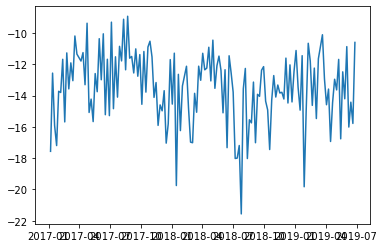

In [29]:
print(len(data_int))
plt.plot(time, data_int)

In [30]:
#changing dates to days since measurement
def days_since(vec):
    days_since = []
    for i in range(0, len(vec)):
        days_since.append((i+1) * 6)
    return days_since

In [37]:
daysince = days_since(time)


In [38]:
#errors found from sentinel paper
error = np.std(data_int)/np.sqrt(len(data_int))
error_data = np.linspace(error, error, len(data_int))

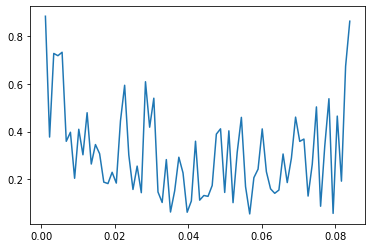

882.1192052980133
0.8843019887543132


In [39]:
#making fft
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 245
Sample = 6

yf = 2.0/len(data_int) * np.abs(fft(data_int)[:len(data_int)//2])[1:]
xf = np.linspace(0.0, len(daysince)/(2.0*(daysince[-1]-daysince[0])), len(daysince)//2)[1:]


plt.plot(np.abs(xf), np.abs(yf))
plt.show()
max_freq=xf[np.argmax(yf)]
power = yf[np.argmax(yf)]
days_max = 1/(max_freq) 
print(days_max)
print(power)


In [40]:
daysince = np.array(daysince)
days_max = 365.25

In [41]:
#minimizing chi-squared to develop sinusoid
import scipy.optimize

def chsquare_sin(x,y,yerr, initial_values, power,days_max):
    def sin_model(x, param_vals):
        return param_vals[0] * days_max + param_vals[1] * np.sin(2*np.pi / days_max * x + param_vals[2]) + param_vals[3]
    def chi_squared(model_params, model, x, y, yerr):
        return np.sum((y - model(x, model_params))/yerr)**2
    #deg_freedom = y.size - initial_values.size # Make sure you understand why!
    fit = scipy.optimize.minimize(chi_squared, initial_values, args=(sin_model, x,y, yerr))
    print(fit)
    a_solution = fit.x[0]
    b_solution = fit.x[1]
    c_solution = fit.x[2]
    d_solution = fit.x[3]
    
    
    plt.figure(figsize=(8,6))
    plt.errorbar(x, 
             y, 
             yerr, 
             marker='o', 
             linestyle='None')

    plt.xlabel('x data (units)') # Axis labels
    plt.ylabel('y data (units)')

# Generate best fit line using model function and best fit parameters, and add to plot
    fit_line = sin_model(x, [a_solution, b_solution, c_solution, d_solution])
    plt.plot(x, fit_line, 'r')
    plt.show()

    return a_solution, b_solution, c_solution, d_solution


      fun: 4.956860387322428e-06
 hess_inv: array([[ 7.59202699e-06, -3.39470119e-06,  3.10224165e-04,
        -2.73783002e-03],
       [-3.39470119e-06,  1.00000000e+00,  1.05311988e-09,
        -9.29412852e-09],
       [ 3.10224165e-04,  1.05311988e-09,  9.99999904e-01,
         8.49342286e-07],
       [-2.73783002e-03, -9.29412852e-09,  8.49342286e-07,
         9.99992504e-01]])
      jac: array([ 0.04360278, -0.00451713,  0.41292813, -3.63312104])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 292
      nit: 1
     njev: 56
   status: 2
  success: False
        x: array([-3.00938596e-06,  8.84301989e-01,  1.57079633e+00, -1.34763038e+01])


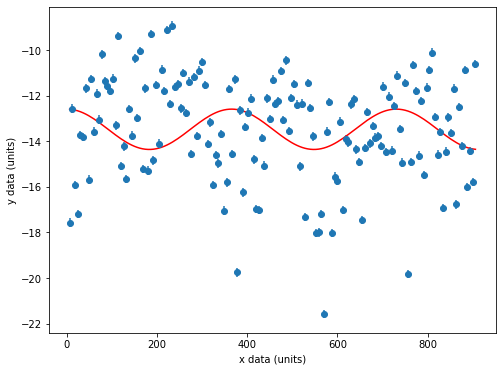

In [42]:
#round 1 of cleaning
in_vals = np.array([0, power, np.pi/2, np.mean(data_int)])
data_int = np.array(data_int)
a_solution, b_solution, c_solution, d_solution = chsquare_sin(daysince, data_int, error_data, in_vals, power,days_max)

0.017202423838958484
365.25


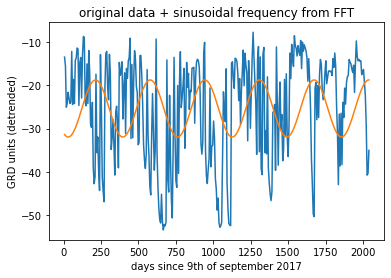

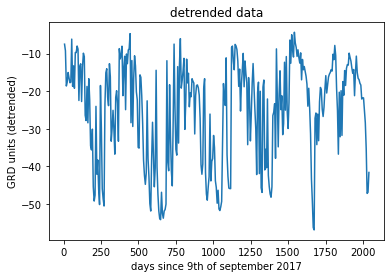

In [47]:
#deleting from original dataset round 1
data_new = []
sinusoid = []
mean = np.mean(data_int)
mult =2*np.pi/(days_max)
print(mult)
print(days_max)
for i in range(0, len(data_int)):
    dat = data_int[i] - (power*np.sin(daysince[i]*mult + (4/3)*np.pi)) 
    sin = power * (np.sin(daysince[i] *mult+4/3*np.pi)) + mean
    data_new.append(dat)
    sinusoid.append(sin)
plt.figure()
plt.title('original data + sinusoidal frequency from FFT')
plt.plot(daysince, data_int)
plt.plot(daysince, sinusoid)
plt.xlabel('days since 9th of september 2017')
plt.ylabel('GRD units (detrended)')
plt.show()
plt.title('detrended data')
plt.xlabel('days since 9th of september 2017')
plt.ylabel('GRD units (detrended)')
plt.plot(daysince, data_new)
plt.show()
#plt.plot(daysince, data_int)


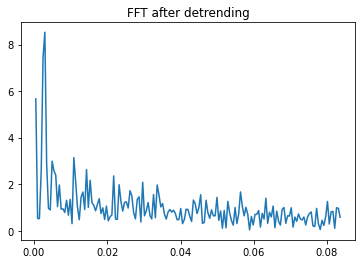

337.00588235294117 8.526910898123614


In [48]:
#showing that i detrended the data
#making fft
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 245
Sample = 6

yf =  2.0/len(data_new) * np.abs(fft(data_new)[:len(data_new)//2])[1:] 
xf = np.linspace(0.0, len(daysince)/(2.0*(daysince[-1]-daysince[0])), len(daysince)//2)[1:]

plt.plot(np.abs(xf), np.abs(yf))
plt.title('FFT after detrending')
plt.show()
max_freq_1=xf[np.argmax(yf)]
power_1 = yf[np.argmax(yf)]
days_max_1 = 1/(max_freq_1) 
print(days_max_1, power_1)

      fun: 5.6634225138590666e-14
 hess_inv: array([[0.00049504]])
      jac: array([-7.58941123e-08])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-0.22340069])


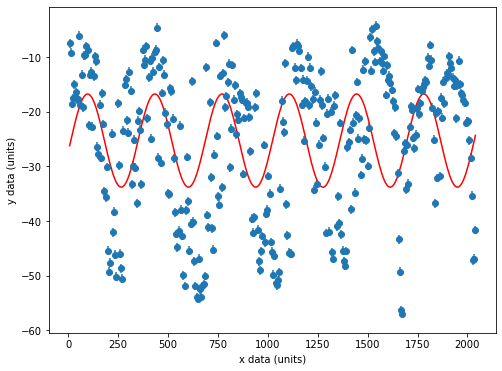

-0.07111064803468817


In [49]:
#round 1 of cleaning
in_vals = np.array([1/3*np.pi/2])
data_int = np.array(data_new)
phase_shift_1 = chsquare_sin(daysince, data_new, error_data, in_vals, power_1,days_max_1)
print(phase_shift_1)

0.018644141352403165
365.25


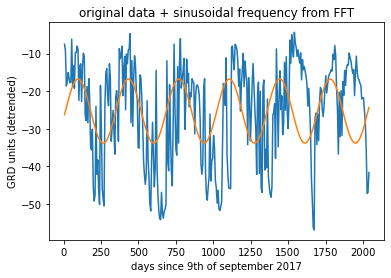

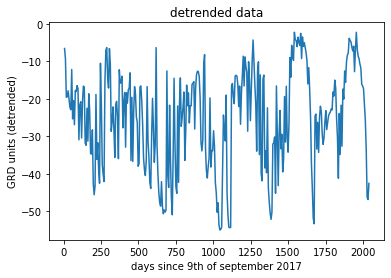

In [53]:
#deleting from original dataset round 1
data_new_new = []
sinusoid = []
mean = np.mean(data_new)
mult =2*np.pi/(days_max_1)
print(mult)
print(days_max)
for i in range(0, len(data_new)):
    dat = data_new[i] - (power_1*np.sin(daysince[i]*mult + (phase_shift_1)*np.pi)) 
    sin = power_1 *(np.sin(daysince[i] *mult+(phase_shift_1)*np.pi)) + mean
    data_new_new.append(dat)
    sinusoid.append(sin)
plt.figure()
plt.title('original data + sinusoidal frequency from FFT')
plt.plot(daysince, data_new)
plt.plot(daysince, sinusoid)
plt.xlabel('days since 9th of september 2017')
plt.ylabel('GRD units (detrended)')
plt.show()
plt.title('detrended data')
plt.xlabel('days since 9th of september 2017')
plt.ylabel('GRD units (detrended)')
plt.plot(daysince, data_new_new)
plt.show()
#plt.plot(daysince, data_int)


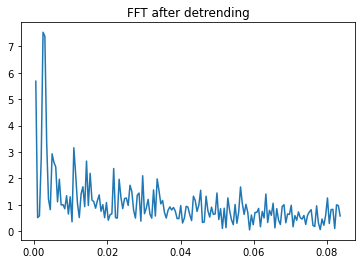

404.4070588235294 7.53789342804361


In [52]:
#showing that i detrended the data
#making fft
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 245
Sample = 6

yf =  2.0/len(data_new_new) * np.abs(fft(data_new_new)[:len(data_new_new)//2])[1:] 
xf = np.linspace(0.0, len(daysince)/(2.0*(daysince[-1]-daysince[0])), len(daysince)//2)[1:]

plt.plot(np.abs(xf), np.abs(yf))
plt.title('FFT after detrending')
plt.show()
max_freq_2=xf[np.argmax(yf)]
power_2 = yf[np.argmax(yf)]
days_max_2 = 1/(max_freq_2) 
print(days_max_2, power_2)

      fun: 3.787038135275101e-09
 hess_inv: array([[991.9432688]])
      jac: array([8.10136758e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 2
     njev: 10
   status: 0
  success: True
        x: array([-0.3185492])


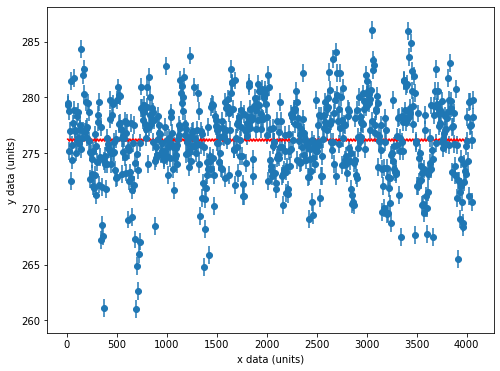

In [113]:
#cleaning out lunar cycle
daysmax_lun = 29.5
power_lun = 0.1 #approximate
init_values_lun = np.array([np.pi/3])
phase_shift_lun = chsquare_sin(daysince, data_new, error_data, init_values_lun, power_lun, daysmax_lun)

In [114]:
data_new_new = []
sinusoid = []
mean = np.mean(data_new_new)
mult =2*np.pi/(daysmax_lun)
print(mult)
print(daysmax_lun)
for i in range(0, len(data)):
    dat = data_new[i] - (power_lun*np.sin(daysince[i]*mult + (phase_shift_lun)*np.pi)) 
    sin = (np.sin(daysince[i] *mult+(phase_shift_lun)*np.pi)) + mean
    data_new_new.append(dat)
    sinusoid.append(sin)
plt.figure()
plt.title('original data + sinusoidal frequency from FFT')
plt.plot(daysince, data_new)
plt.plot(daysince, sinusoid)
plt.xlabel('days since 9th of september 2017')
plt.ylabel('GRD units (detrended)')
plt.show()
plt.title('detrended data')
plt.xlabel('days since 9th of september 2017')
plt.ylabel('GRD units (detrended)')
plt.plot(daysince, data_new_new)
plt.show()
#plt.plot(daysince, data_int)

0.21298933244676563
29.5


/Users/sarahcliff/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahcliff/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

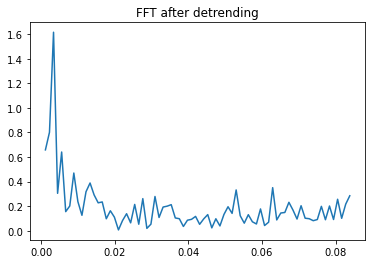

302.0387096774194 1.6153414393698795


In [33]:
#showing that i detrended the data for lunar cycle
#making fft
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 245
Sample = 6

yf =  2.0/len(data_new_new) * np.abs(fft(data_new_new)[:len(data_new)//2])[1:] 
xf = np.linspace(0.0, len(daysince)/(2.0*(daysince[-1]-daysince[0])), len(daysince)//2)[1:]

plt.plot(np.abs(xf), np.abs(yf))
plt.title('FFT after detrending')
plt.show()
max_freq_lun=xf[np.argmax(yf)]
power_lun_1 = yf[np.argmax(yf)]
days_max_lun_1 = 1/(max_freq_1) 
print(days_max_lun_1, power_lun_1)

In [28]:
#linear test
import scipy.optimize
def chsquare_lin(x,y,yerr, initial_values):
    def linear_model(x, param_vals):
        return param_vals[0] + param_vals[1]*x
    def chi_squared(model_params, model, x, y, yerr):
        return np.sum((y - model(x, model_params))/yerr)**2
    #deg_freedom = y.size - initial_values.size # Make sure you understand why!
    fit = scipy.optimize.minimize(chi_squared, initial_values, args=(linear_model, x,y, yerr))
    print(fit)
    a_solution = fit.x[0]
    b_solution = fit.x[1]
    
    plt.figure(figsize=(8,6))
    plt.errorbar(x, 
             y, 
             yerr, 
             marker='o', 
             linestyle='None')

    plt.xlabel('x data (units)') # Axis labels
    plt.ylabel('y data (units)')

# Generate best fit line using model function and best fit parameters, and add to plot
    fit_line = linear_model(x, [a_solution, b_solution])
    plt.plot(x, fit_line, 'r')
    plt.show()

    return a_solution, b_solution

In [29]:
data_new_new = np.array(data_int)
x_fit, y_fit = chsquare_lin(daysince, data_int, error_data, [np.mean(data_int), 1])


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [32]:
#stationary tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

#dickey fuller 
X = data_int
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
#Kwiatkowski-Phillips-Schmidt-Shin test
result_kpss = kpss(data_int, regression = 'c', nlags = 'auto')
print('KPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.220015
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
KPSS Statistic: 0.891871
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/sarahcliff/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


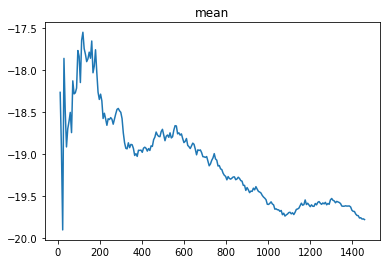

Text(0.5, 1.0, 'variance')

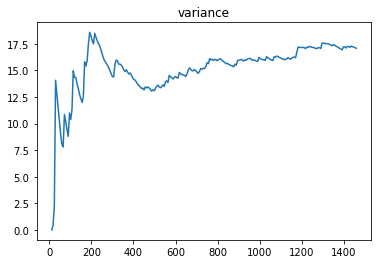

In [33]:
#testing if mean and variance of data remain the same
mean = []
variance = []
for i in range(1, len(data_int)):
    mean.append(np.mean(data_int[0:i]))
    variance.append(np.var(data_int[0:i]))
    
plt.plot(daysince[1:], mean)
plt.title('mean')
plt.show()
plt.plot(daysince[1:], variance)
plt.title('variance')

In [104]:
#shows we have a pretty stationary dataset

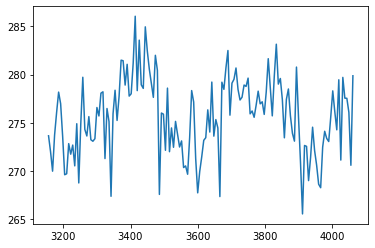

In [125]:
new_time = list(new_time)
start_index= new_time.index(datetime(2017, 9, 12, 0, 0))
lst_adjust = data_new_new[start_index:-1]
date_adjust = daysince[start_index:-1]
plt.plot(date_adjust, lst_adjust)

In [126]:
time_array_df = date_adjust
data = {'Days Since': time_array_df, 'GRD Measurement': lst_adjust}  
df_data = pd.DataFrame(data)
#creating filename
filename='lstnightdetrended@'+ str(datetime.now().strftime("%Y-%m-%d"))+'.csv'
df_data.to_csv(filename)
